In [1]:
#PyTorch Training and using checkpointing on SageMaker Managed Spot Training
# SageMaker Managed Spot uses EC2 Spot Instances to run Training at a lower cost.

In [2]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

SageMaker version: 2.72.1
Checkpointing Path: s3://sagemaker-us-east-1-499554417458/checkpoint-9ae72e42


In [3]:
import os
import subprocess

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

Instance type = local


In [4]:
# Download the Cifar10 dataset
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


    horse      deer      deer       car


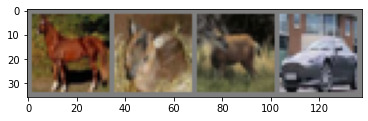

In [5]:
# Data preview
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [6]:
# Upload the data
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix='data/cifar10')

In [7]:
!pygmentize source_dir/cifar10.py

import argparse
import logging
import time
import json
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import torch.nn.functional as F

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(s

Create a training job using the sagemaker.PyTorch estimator
The PyTorch class allows us to run our training function on SageMaker. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. For local training with GPU, we could set this to "local_gpu". In this case, instance_type was set above based on your whether you're running a GPU instance.

After we've constructed our PyTorch object, we fit it using the data we uploaded to S3. Even though we're in local mode, using S3 as our data source makes sense because it maintains consistency with how SageMaker's distributed, managed training ingests data.

In [8]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 2}

cifar10_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            hyperparameters=hyperparameters,
                            instance_count=1,
                            instance_type=instance_type)

cifar10_estimator.fit(inputs)

Creating fszl3c8ag5-algo-1-gfza6 ... 
Creating fszl3c8ag5-algo-1-gfza6 ... done
Attaching to fszl3c8ag5-algo-1-gfza6
fszl3c8ag5-algo-1-gfza6 | 2022-01-18 12:18:14,664 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
fszl3c8ag5-algo-1-gfza6 | 2022-01-18 12:18:14,666 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
fszl3c8ag5-algo-1-gfza6 | 2022-01-18 12:18:14,679 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
fszl3c8ag5-algo-1-gfza6 | 2022-01-18 12:18:14,692 sagemaker_pytorch_container.training INFO     Invoking user training script.
fszl3c8ag5-algo-1-gfza6 | 2022-01-18 12:18:14,929 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
fszl3c8ag5-algo-1-gfza6 | 2022-01-18 12:18:14,945 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
fszl3c8ag5-algo-1-gfza6 | 2022-01-18 12:18:14,960 sagemaker-training-toolkit 

In [9]:
print('check')

check


Run a baseline training job on SageMaker
Now we run training jobs on SageMaker, starting with our baseline training job.

Once again, we create a PyTorch estimator, with a couple key modfications from last time:

instance_type: the instance type for training. We set this to ml.p3.2xlarge because we are training on SageMaker now. For a list of available instance types, see the AWS documentation.
metric_definitions: the metrics (defined above) that we want sent to CloudWatch.

In [10]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 10}

cifar10_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            hyperparameters=hyperparameters,
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch')

cifar10_estimator.fit(inputs)

2022-01-18 12:21:30 Starting - Starting the training job...
2022-01-18 12:21:59 Starting - Launching requested ML instancesProfilerReport-1642508489: InProgress
......
2022-01-18 12:22:59 Starting - Preparing the instances for training............
2022-01-18 12:25:00 Downloading - Downloading input data...
2022-01-18 12:25:20 Training - Downloading the training image...............
2022-01-18 12:28:00 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-18 12:27:52,011 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-18 12:27:52,047 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-18 12:27:55,072 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-18 12:27:55,749 sagemaker-training-toolkit INFO     Invoking user script
Traini

Managed Spot Training with a PyTorch Estimator
For Managed Spot Training using a PyTorch Estimator we need to configure two things:

Enable the train_use_spot_instances constructor arg - a simple self-explanatory boolean.
Set the train_max_wait constructor arg - this is an int arg representing the amount of time you are willing to wait for Spot infrastructure to become available. Some instance types are harder to get at Spot prices and you may have to wait longer. You are not charged for time spent waiting for Spot infrastructure to become available, you're only charged for actual compute time spent once Spot instances have been successfully procured.
Normally, a third requirement would also be necessary here - modifying your code to ensure a regular checkpointing cadence - however, PyTorch Estimators already do this, so no changes are necessary here. Checkpointing is highly recommended for Manage Spot Training jobs due to the fact that Spot instances can be interrupted with short notice and using checkpoints to resume from the last interruption ensures you don't lose any progress made before the interruption.

Feel free to toggle the use_spot_instances variable to see the effect of running the same job using regular (a.k.a. "On Demand") infrastructure.

Note that max_wait can be set if and only if use_spot_instances is enabled and must be greater than or equal to max_run.

In [11]:
print('check')

check


In [12]:
use_spot_instances = True
max_run=600
max_wait = 1200 if use_spot_instances else None

Simulating Spot interruption after 5 epochs
Our training job should run on 10 epochs.

However, we will simulate a situation that after 5 epochs a spot interruption occurred.

The goal is that the checkpointing data will be copied to S3, so when there is a spot capacity available again, the training job can resume from the 6th epoch.

Note the checkpoint_s3_uri variable which stores the S3 URI in which to persist checkpoints that the algorithm persists (if any) during training.

The debugger_hook_config parameter must be set to False to enable checkpoints to be copied to S3 successfully.

In [13]:
hyperparameters = {'epochs': 5}


spot_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch-spot-1',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)

spot_estimator.fit(inputs)

2022-01-18 12:44:36 Starting - Starting the training job...
2022-01-18 12:45:03 Starting - Launching requested ML instancesProfilerReport-1642509875: InProgress
...
2022-01-18 12:45:25 Starting - Insufficient capacity error from EC2 while launching instances, retrying!......
2022-01-18 12:46:24 Starting - Preparing the instances for training...............
2022-01-18 12:49:04 Downloading - Downloading input data...
2022-01-18 12:49:24 Training - Downloading the training image.........
2022-01-18 12:51:07 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-18 12:51:08,387 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-18 12:51:08,410 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-18 12:51:11,430 sagemaker_pytorch_container.training INFO     Invoking use

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


Training seconds: 658
Billable seconds: 197
Managed Spot Training savings: 70.1%


In [14]:
print('check')

check


In [15]:
hyperparameters = {'epochs': 10}


spot_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch-spot-2',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)

spot_estimator.fit(inputs)

2022-01-18 13:02:33 Starting - Starting the training job...
2022-01-18 13:02:36 Starting - Launching requested ML instancesProfilerReport-1642510952: InProgress
...
2022-01-18 13:03:31 Starting - Insufficient capacity error from EC2 while launching instances, retrying!.............................................................................................ProfilerReport-1642510952: Stopped
..............................
2022-01-18 13:24:04 Stopping - Stopping the training job
2022-01-18 13:24:04 MaxWaitTimeExceeded - Training job wait time exceeded MaxWaitTimeInSeconds provided
..

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


In [16]:
print('check')

check


Analyze training job logs
Analyzing the training job logs, we can see that now, the training job starts from the 6th epoch.

We can see the output of _load_checkpoint function:

--------------------------------------------
Checkpoint file found!
Loading Checkpoint From: /opt/ml/checkpoints/checkpoint.pth
Checkpoint File Loaded - epoch_number: 5 - loss: 0.8455273509025574
Resuming training from epoch: 6
--------------------------------------------
View the job training Checkpoint configuration after job completed 10 epochs
We can now view the Checkpoint configuration from the training job directly in the SageMaker console.

Log into the SageMaker console, choose the latest training job, and scroll down to the Checkpoint configuration section.

Choose the S3 output path link and you'll be directed to the S3 bucket were checkpointing data is saved.

You can see there is still that one file there:

checkpoint.pth
You'll be able to see that the date of the checkpoint file was updated to the time of the 2nd Spot training job.

Deploy the trained model to prepare for predictions
The deploy() method creates an endpoint which serves prediction requests in real-time.

In [ ]:
from sagemaker.pytorch import PyTorchModel

predictor = spot_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Invoking the endpoint

In [ ]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted: ', ' '.join('%4s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
Clean-up
To avoid incurring extra charges to your AWS account, let's delete the endpoint we created:

In [ ]:
predictor.delete_endpoint()